In [1]:
import keras
import tensorflow as tf

In [2]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [5]:
base_dir = Path(r'e:\Google Drive\research\projects\utica')
mask_dir = base_dir.joinpath('mask')
train_image_dir = mask_dir.joinpath('u_train_reproject')
trees_mask_dir = mask_dir.joinpath('trees')
building_mask_dir = mask_dir.joinpath('building')
pavement_mask_dir = mask_dir.joinpath('pavement')

In [6]:
I, N, M = 40, 256, 256

In [7]:
os.listdir(mask_dir)

['building', 'desktop.ini', 'pavement', 'trees', 'u_train_reproject']

In [8]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [9]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [10]:
def load_image(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()[6:-7,6:-6]

In [11]:
def sorted_paths(img_dir: Path):
    return sorted(glob(img_dir.joinpath('*.tif').as_posix()), key=img_number)

In [12]:
def load_stack_safely(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1)
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, :, :] = load_image(image_path)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [13]:
train_images = load_stack_safely((I, N, M), np.float32, train_image_dir, "wgs_train")
tree_masks = load_stack_safely((I, N, M), np.int8, trees_mask_dir, "tree_mask")
building_masks = load_stack_safely((I, N, M), np.int8, building_mask_dir, "building_mask")
pavement_masks = load_stack_safely((I, N, M), np.int8, pavement_mask_dir, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_8.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_19.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_27.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_31.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_34.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_8.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_19.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_27.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_31.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_34.tif
skipping e:\Google Drive\research\projects\utica\mask\pavement\pavement_mask_19.tif
skipping e:\Google Drive\research\projects\utica\mask\pavement\pavement_mask_2

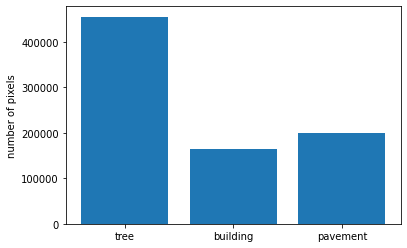

In [14]:
fig, ax = plt.subplots()
ax.bar(range(3), [tree_masks.sum(), building_masks.sum(), pavement_masks.sum()])
ax.set_xticks((0, 1, 2))
ax.set_xticklabels(('tree', 'building', 'pavement'))
plt.ylabel('number of pixels')
plt.show()

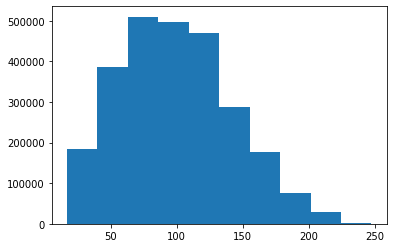

In [15]:
plt.hist(train_images.flatten())
plt.show()

In [16]:
model = satellite_unet(
    (N, M, 1),
    3,
    # dropout_type="spatial"
)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded],
    
)

In [18]:
Y = np.zeros(shape=(I, N, M, 3), dtype=np.int8)
Y[:, :, :, 0] = tree_masks
Y[:, :, :, 1] = building_masks
Y[:, :, :, 2] = pavement_masks

In [19]:
Y.shape, tree_masks.shape

((40, 256, 256, 3), (40, 256, 256))

In [20]:
history = model.fit(
    train_images.reshape(I, N, M, 1),
    Y,
)

2/2 [==============================] - 20s 4s/step - loss: 0.7214 - iou: 0.1024 - iou_thresholded: 0.1185


In [ ]:
Y_pred = model.predict(train_images.reshape(I, N, M, 1))